# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?
- What exactly is your deliverable: your analysis, or the model itself?
- Does your business understanding/stakeholder require a specific type of model?
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
   

Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [2]:
# Standard Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# NLP imports

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
import string
import re

In [4]:
# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
# Utility import

from util import evaluate_model

In [6]:
# Download stopwords

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Set Pandas options
pd.set_option('display.max_colwidth', None)

In [7]:
# Import data

tweet_df = pd.read_csv('./../../Data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

In [8]:
# Change column names to something more readable

tweet_df.columns = ['tweet', 'product/company', 'emotion']

In [9]:
tweet_df.head(5)

,tweet,product/company,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [10]:
# Explore distribution of target variable. 60% are netural, 33% are positive, and only 6% are negative

tweet_df['emotion'].value_counts(normalize = True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [11]:
# Explore nulls in tweets. There is one blank tweet.

tweet_df.isna().sum()

tweet                 1
product/company    5802
emotion               0
dtype: int64

In [12]:
# Check for duplicates
# There are 27 duplicate tweets

tweet_df.duplicated('tweet').sum()

27

In [16]:
# Explore nulls for where product / company is null
# Most of the nulls for product / company are neutral

no_brand = tweet_df[tweet_df['product/company'].isna()]

no_brand['emotion'].value_counts()

No emotion toward brand or product    5298
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: emotion, dtype: int64

In [13]:
# Almost all of the "can't tell" emotions do not have a product associated with them.
# Plan is to drop these rows unless we can fill in some of the values with Text Blob

cant_tell = tweet_df[tweet_df['emotion'] == "I can't tell"]

cant_tell['product/company'].isna().sum() / cant_tell.shape[0]

0.9423076923076923

In [14]:
# Determine value counts of brands

brand_list = list(tweet_df['product/company'].value_counts().index)

brand_list

['iPad',
 'Apple',
 'iPad or iPhone App',
 'Google',
 'iPhone',
 'Other Google product or service',
 'Android App',
 'Android',
 'Other Apple product or service']

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [15]:
# Drop the single null tweet

df_clean = tweet_df.dropna(subset=['tweet'])

In [16]:
# Drop the duplicate tweets

df_clean = df_clean.drop_duplicates(subset='tweet')

In [17]:
# Define function to fill in missing brands

def fill_brand(product, tweet):
    
    apple_keywords = ['Apple', 'iPhone', 'iPad', 'iTunes', 'Other Apple product or service',
                     'iPad or iPhone App', 'apple', 'iphone', 'ipad', 'itunes']
    google_keywords = ['Google', 'google', 'Android', 'android', 'Other Google product or service',
                      'Android App']
    
    apple_mentions = 0
    google_mentions = 0
    
    for word in tweet.split(' '):
        if word.translate(str.maketrans('', '', string.punctuation)).lower() in apple_keywords:
            apple_mentions += 1
        elif word.translate(str.maketrans('', '', string.punctuation)).lower() in google_keywords:
            google_mentions += 1
    
    if product in apple_keywords:
        brand = 'Apple'
    elif product in google_keywords:
        brand = 'Google'
    elif (apple_mentions > 0) & (not google_mentions):
        brand = 'Apple'
    elif (not apple_mentions) & (google_mentions > 0):
        brand = 'Google'
    elif (apple_mentions > 0) & (google_mentions > 0):
        brand = 'Both'
    else:
        brand = 'Unknown'
    
    return brand

In [18]:
# Apply the function to the new brand column

df_clean['brand'] = df_clean.apply(lambda row: fill_brand(row['product/company'], row['tweet']), axis=1)

In [19]:
# Display value counts for the brands

df_clean['brand'].value_counts()

Apple      5266
Google     2572
Unknown    1076
Both        151
Name: brand, dtype: int64

### The following cells will add a "clean tweets" column with some basic cleaning steps

- Remove URLs
- TBD

In [20]:
df_clean['clean_tweet'] = df_clean['tweet']

In [21]:
# Remove hyperlinks
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'(http://[^"\s]+)|(@\w+)', '', x))
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'(https://[^"\s]+)|(@\w+)', '', x))
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

# Remove {link} and [video] references
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'{link}', '', x))
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'\[video\]', '', x))

# Replace these characters (which appear in place of an apostrophe)
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: x.replace('Ûª', "'"))

# Remove hastag but keep the words
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'#', '', x))

# Remove @ handles but keep the mentions
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'@', '', x))

In [22]:
df_clean.head(20)

,tweet,product/company,emotion,brand,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,. I have a 3G iPhone. After 3 hrs tweeting at ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about ? Awesome iPad/iPhone app that yo...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,Can not wait for iPad 2 also. They should sal...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,I hope this year's festival isn't as crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,great stuff on Fri SXSW: Marissa Mayer (Googl...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,Apple,New iPad Apps For SpeechTherapy And Communica...
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,Google,"SXSW is just starting, CTIA is around the corn..."
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,Apple,Beautifully smart and simple idea RT wrote a...
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,Apple,Counting down the days to sxsw plus strong Can...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,Google,Excited to meet the at sxsw so I can show the...


In [25]:
# Do a count vectorizer to check for weird symbols that should be removed

ct_vectorizer = CountVectorizer()
ct_vectorizer.fit(df_clean['clean_tweet'])
clean_tweet_vec = ct_vectorizer.transform(df_clean['clean_tweet'])

ct_vect_df = pd.DataFrame(clean_tweet_vec.toarray(),
                          columns=ct_vectorizer.get_feature_names())

ct_vect_cols = list(ct_vect_df.columns)

# ct_vect_cols[-64:]

In [26]:
# Define function to remove symbols that appear at the bottom of the count vectorizer

def remove_symbols(text):
    symbols_to_remove = ['ª¼', 'ªè', '¼¼', '¾û', 'á¾_î¾ð', 'áî', 'â_', 'ââ', 'âã', 'ã_', 'ä_', 'ä___ü', 'äá',
                         'å_', 'åç', 'åè', 'çü', 'èï', 'ìù', 'ïà', 'ïî', 'ïö', 'ð_', 'ðü', 'öý', 'ù_¾', 'û_',
                         'û_a', 'û_', 'û¼', 'û', 'ûï', 'ûò', 'ü_', 'ÛÏ', 'Û']
    
    clean_text = text
    
    for symbol in symbols_to_remove:
        clean_text = clean_text.replace(symbol, '')
    
    return clean_text

In [27]:
# Remove symbols

df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: remove_symbols(x))

In [28]:
# Define function to remove stop words and punctuation

def remove_stop(text):
    
    # Instantiate a tweet tokenizer
    tweet_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)
    
    clean_text = text
    
    # Tokenize the sweets
    tweet_token = tweet_tokenizer.tokenize(clean_text)
    
    # Remove stop words and punctuation
    stop_words = stopwords.words('english')
    stop_words += list(string.punctuation)
    stop_words += ['SXSW', 'sxsw']
    
    stop_tweet_token = [word for word in tweet_token if word not in stop_words]
    stop_tweet_token = [word.lower() for word in stop_tweet_token]
    
    clean_text = " ".join(stop_tweet_token)
    
    return clean_text

In [29]:
# Remove symbols

df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: remove_stop(x))

In [30]:
df_clean.head(20)

,tweet,product/company,emotion,brand,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,wait ipad 2 also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,hope year's festival crashy year's iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,great stuff fri marissa mayer google tim o'rei...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,Apple,new ipad apps speechtherapy communication show...
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,Google,starting ctia around corner googleio hop skip ...
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,Apple,beautifully smart simple idea rt wrote hollerg...
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,Apple,counting days plus strong canadian dollar mean...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,Google,excited meet show sprint galaxy still running ...


In [31]:
# Create a sentiment target and map it

target_map = {'Positive emotion': 1,
              'No emotion toward brand or product': 0,
              'Negative emotion': 0,
              "I can't tell": 0}

# Map it
df_clean['sentiment'] = df_clean['emotion'].map(target_map)

In [35]:
df_clean.head()

,tweet,product/company,emotion,brand,clean_tweet,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,Apple,3g iphone 3 hrs tweeting rise_austin dead need upgrade plugin stations,0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,Apple,know awesome ipad iphone app likely appreciate design also they're giving free ts,1
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,Apple,wait ipad 2 also sale,1
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,Apple,hope year's festival crashy year's iphone app,0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,Google,great stuff fri marissa mayer google tim o'reilly tech books conferences matt mullenweg wordpress,1


## Data Exploration

- Data exploration on the clean dataset

In [32]:
from wordcloud import WordCloud

In [33]:
from collections import Counter

In [34]:
def tokenize(tweet):
    
    tokenizer = RegexpTokenizer(pattern='(?u)\\b\\w\\w+\\b')
    
    tokens = tokenizer.tokenize(tweet)
    
    return tokens
df_clean['tokens'] = df_clean['clean_tweet'].apply(lambda x: tokenize(x))
token_list = df_clean['tokens'].sum()
freq_dist = FreqDist(token_list)

In [143]:
# draw a Word Cloud with word frequencies
# wordcloud = WordCloud(width=900,
#                       height=500,
#                       max_words=500,
#                       relative_scaling=0.5,
#                       max_font_size=100,
#                       colormap='Blues').generate_from_frequencies(freq_dist)
# plt.figure(figsize=(17,14))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

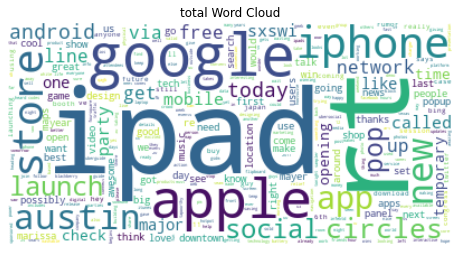

In [35]:
p_wc = WordCloud(background_color="white", max_words=500)
p_wc.generate_from_frequencies(freq_dist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('total Word Cloud')
plt.show()

#### Word cloud by brands

In [36]:
apple_df = df_clean[df_clean['brand'] == 'Apple']
google_df = df_clean[df_clean['brand'] == 'Google']
both_df = df_clean[df_clean['brand'] == 'Both']
other_df = df_clean[df_clean['brand'] == 'Unknown']

#### Apple

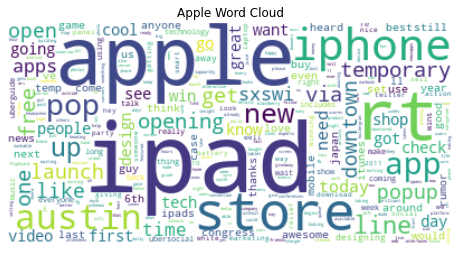

In [37]:
apple_token_list = apple_df['tokens'].sum()
freq_dist_apple = FreqDist(apple_token_list)
p_wc_1 = WordCloud(background_color="white", max_words=500)
p_wc_1.generate_from_frequencies(freq_dist_apple)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_1, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Apple Word Cloud')
plt.show()

In [39]:
apple_positive_df = apple_df[apple_df['sentiment'] == 1]
apple_negative_df = apple_df[apple_df['sentiment'] == 0]

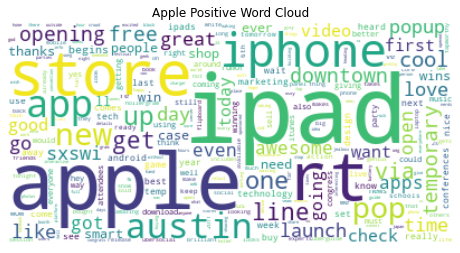

In [40]:
ap_token_list = apple_positive_df['tokens'].sum()
freq_dist_ap = FreqDist(ap_token_list)
p_wc_ap = WordCloud(background_color="white", max_words=500)
p_wc_ap.generate_from_frequencies(freq_dist_ap)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_ap, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Apple Positive Word Cloud')
plt.show()

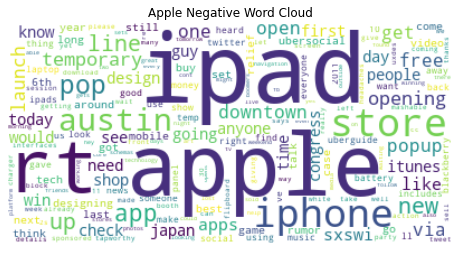

In [41]:
an_token_list = apple_negative_df['tokens'].sum()
freq_dist_an = FreqDist(an_token_list)
p_wc_an = WordCloud(background_color="white", max_words=500)
p_wc_an.generate_from_frequencies(freq_dist_an)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_an, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Apple Negative Word Cloud')
plt.show()

#### Google

In [85]:
go_word = [word for word in google_df['tokens'].sum() if word not in ['google', 'rt', 'called']]
# print(go_word)

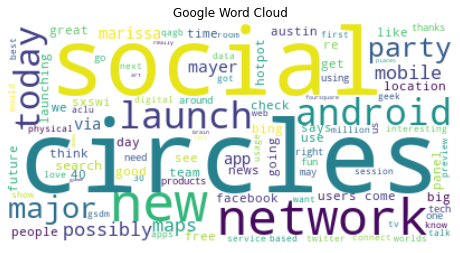

In [86]:
# google_token_list = google_df['tokens'].sum()
freq_dist_google = FreqDist(go_word)
p_wc_g = WordCloud(background_color="white", max_words=100)
p_wc_g.generate_from_frequencies(freq_dist_google)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_g, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Google Word Cloud')
plt.show()

In [87]:
google_positive_df = google_df[google_df['sentiment'] == 1]
google_negative_df = google_df[google_df['sentiment'] == 0]

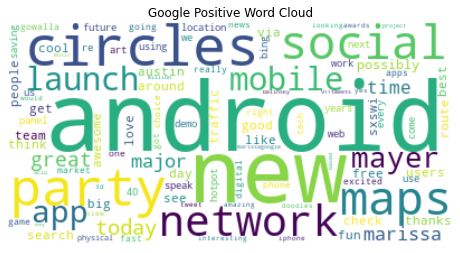

In [88]:
gp_token_list = [word for word in google_positive_df['tokens'].sum() if word not in ['google', 'rt', 'called']]
#  google_positive_df['tokens'].sum()
freq_dist_gp = FreqDist(gp_token_list)
p_wc_gp = WordCloud(background_color="white", max_words=100)
p_wc_gp.generate_from_frequencies(freq_dist_gp)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_gp, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Google Positive Word Cloud')
plt.show()

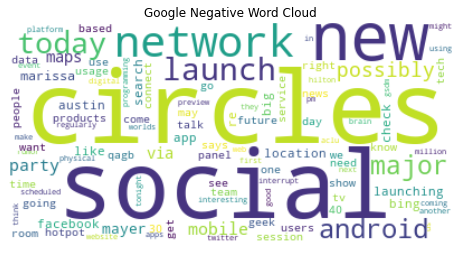

In [90]:
gn_token_list = [word for word in google_negative_df['tokens'].sum() if word not in ['google', 'rt', 'called', 'sxswi']]
freq_dist_gn = FreqDist(gn_token_list)
p_wc_gn = WordCloud(background_color="white", max_words=100)
p_wc_gn.generate_from_frequencies(freq_dist_gn)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_gn, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Google Negative Word Cloud')
plt.show()

#### Apple and Google

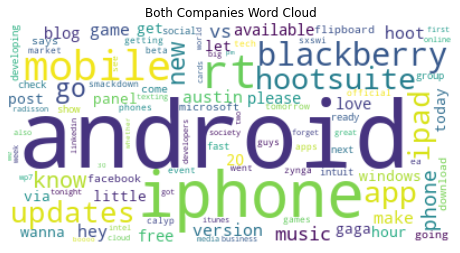

In [91]:
both_token_list = [word for word in both_df['tokens'].sum() if word not in ['google', 'apple']]
freq_dist_both = FreqDist(both_token_list)
p_wc_b = WordCloud(background_color="white", max_words=100)
p_wc_b.generate_from_frequencies(freq_dist_both)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_b, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Both Companies Word Cloud')
plt.show()

#### Other competitors

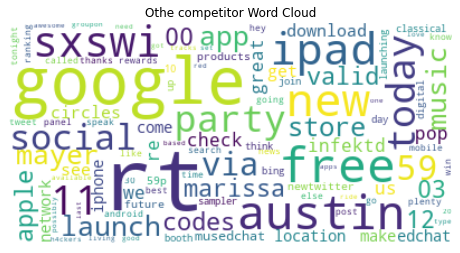

In [47]:
comp_token_list = other_df['tokens'].sum()
freq_dist_comp = FreqDist(comp_token_list)
p_wc_c = WordCloud(background_color="white", max_words=500)
p_wc_c.generate_from_frequencies(freq_dist_comp)

plt.figure(figsize=(8,8))
plt.imshow(p_wc_c, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Othe competitor Word Cloud')
plt.show()

### Word cloud by sentiment

In [48]:
positive_df = df_clean[df_clean['sentiment'] == 1]
negative_df = df_clean[df_clean['sentiment'] == 0]

#### Positive sentiment

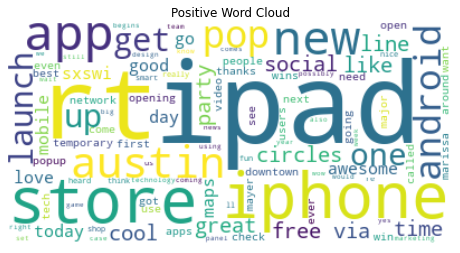

In [82]:
pos_token_list = [word for word in positive_df['tokens'].sum() if word not in ['google', 'apple']]
freq_dist_pos = FreqDist(pos_token_list)
po_wc = WordCloud(background_color="white", max_words=100)
po_wc.generate_from_frequencies(freq_dist_pos)

plt.figure(figsize=(8,8))
plt.imshow(po_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Positive Word Cloud')
plt.show()

#### Not positive Sentiments

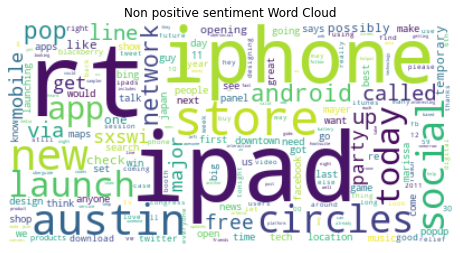

In [84]:
neg_token_list = [word for word in negative_df['tokens'].sum() if word not in ['google', 'apple']]
freq_dist_neg = FreqDist(neg_token_list)
neg_wc = WordCloud(background_color="white", max_words=200)
neg_wc.generate_from_frequencies(freq_dist_neg)

plt.figure(figsize=(8,8))
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Non positive sentiment Word Cloud')
plt.show()

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

In [37]:
# First model is simple multinomial naive bayes

# Define our X and y
X = df_clean['clean_tweet']
y = df_clean['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
vectorizer = CountVectorizer()  

In [39]:
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [42]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [43]:
# code here for your first 'substandard' model

In [44]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [45]:
from nltk.stem.snowball import SnowballStemmer

In [46]:
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(document)
    stemed_text = [stemmer.stem(token) for token in tokens]
    clean_text = " ".join(stemed_text)    
    return clean_text

In [ ]:
# def lemma_and_tokenize(document):
#     tokenizer = TweetTokenizer()
#     tokenz = tokenizer.tokenize(document)
#     lemm_text = [lemm]

In [47]:
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: stem_and_tokenize(x))

In [48]:
# Other models 
# Define our X and y
X = df_clean['clean_tweet']
y = df_clean['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [49]:
# code here to iteratively improve your models

In [50]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [51]:
# svm models
vectorizer_svm = TfidfVectorizer()  
vectorizer_svm.fit(X_train)
X_train_vec_svm = vectorizer_svm.transform(X_train)
X_test_vec_svm = vectorizer_svm.transform(X_test)

clf_svm = SVC()
clf_svm.fit(X_train_vec_svm, y_train)
clf_svm.score(X_test_vec_svm, y_test)

0.7534186149095721

Accuracy: 0.7534
Precision: 0.7459
Recall: 0.7534
F1 Score: 0.7283
ROC: 0.7739


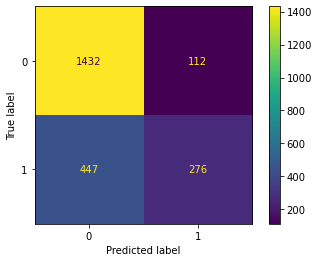

In [52]:
svm_tf = evaluate_model(clf_svm, X_test_vec_svm, y_test, plot_cf = True)

In [53]:
cv_vectorizer_svm = CountVectorizer()  
cv_vectorizer_svm.fit(X_train)
cv_X_train_vec_svm = cv_vectorizer_svm.transform(X_train)
cv_X_test_vec_svm = cv_vectorizer_svm.transform(X_test)

clf_svm_2 = SVC()
clf_svm_2.fit(cv_X_train_vec_svm, y_train)
clf_svm_2.score(cv_X_test_vec_svm, y_test)

0.7534186149095721

Accuracy: 0.7534
Precision: 0.7510
Recall: 0.7534
F1 Score: 0.7226
ROC: 0.7813


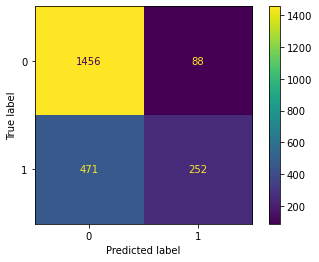

In [54]:
svm_ct = evaluate_model(clf_svm_2, cv_X_test_vec_svm, y_test, plot_cf = True)

In [55]:
# Sgd classifier 
# vectorizer_sgd = TfidfVectorizer()  
# vectorizer_sgd.fit(X_train)
# X_train_vec_sgd = vectorizer_sgd.transform(X_train)
# X_test_vec_sgd = vectorizer_sgd.transform(X_test)

# clf_sgd = SGDClassifier()
# clf_sgd.fit(X_train_vec_sgd, y_train)
# clf_sgd.score(X_test_vec_sgd, y_test)

In [56]:
# results_tf_sgd = evaluate_model(clf_sgd, X_test_vec_sgd, y_test, plot_cf = True)

In [57]:
# cv_vectorizer_sgd = CountVectorizer()  
# cv_vectorizer_sgd.fit(X_train)
# cv_X_train_vec_sgd = cv_vectorizer_sgd.transform(X_train)
# cv_X_test_vec_sgd = cv_vectorizer_sgd.transform(X_test)

# clf_sgd_2 = SGDClassifier()
# clf_sgd_2.fit(cv_X_train_vec_sgd, y_train)
# clf_sgd_2.score(cv_X_test_vec_sgd, y_test)

In [58]:
# results_cf_sgd  = evaluate_model(clf_sgd_2, cv_X_test_vec_sgd, y_test, plot_cf = True)

In [59]:
vectorizer_bayes = TfidfVectorizer()  
vectorizer_bayes.fit(X_train)
X_train_vec_bayes = vectorizer_bayes.transform(X_train)
X_test_vec_bayes = vectorizer_bayes.transform(X_test)

clf_bayes = MultinomialNB()
clf_bayes.fit(X_train_vec_bayes, y_train)
clf_bayes.score(X_test_vec_bayes, y_test)

0.7212174680194089

Accuracy: 0.7212
Precision: 0.7256
Recall: 0.7212
F1 Score: 0.6606
ROC: nan


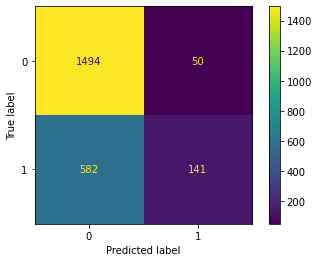

In [60]:
bayes_tf  = evaluate_model(clf_bayes, X_test_vec_bayes, y_test, plot_cf = True)

In [61]:
cv_vectorizer_bayes = CountVectorizer()  
cv_vectorizer_bayes.fit(X_train)
cv_X_train_vec_bayes = cv_vectorizer_bayes.transform(X_train)
cv_X_test_vec_bayes = cv_vectorizer_bayes.transform(X_test)

clf_sgd_bayes = MultinomialNB()
clf_sgd_bayes.fit(cv_X_train_vec_bayes, y_train)
clf_sgd_bayes.score(cv_X_test_vec_bayes, y_test)

0.7075430083811204

Accuracy: 0.7075
Precision: 0.6997
Recall: 0.7075
F1 Score: 0.7027
ROC: nan


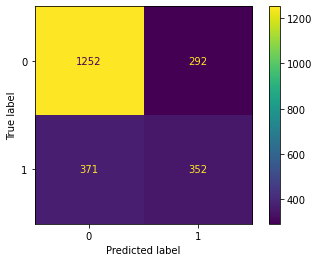

In [62]:
bayes_ct  = evaluate_model(clf_sgd_bayes, cv_X_test_vec_bayes, y_test, plot_cf = True)

In [63]:
# Random forest 
vectorizer_forest = TfidfVectorizer()  
vectorizer_forest.fit(X_train)
X_train_vec_forest = vectorizer_forest.transform(X_train)
X_test_vec_forest = vectorizer_forest.transform(X_test)

clf_forest = RandomForestClassifier()
clf_forest.fit(X_train_vec_forest, y_train)
clf_forest.score(X_test_vec_forest, y_test)

0.7401852668725187

Accuracy: 0.7402
Precision: 0.7265
Recall: 0.7402
F1 Score: 0.7201
ROC: nan


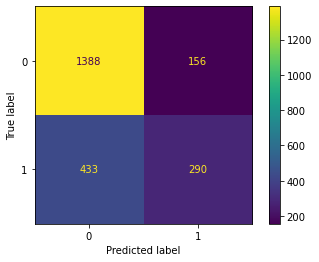

In [64]:
rf_tf = evaluate_model(clf_forest, X_test_vec_forest, y_test, plot_cf = True)

In [65]:
cv_vectorizer_forest = CountVectorizer()  
cv_vectorizer_forest.fit(X_train)
cv_X_train_vec_forest = cv_vectorizer_forest.transform(X_train)
cv_X_test_vec_forest = cv_vectorizer_forest.transform(X_test)

clf_forest_2 = RandomForestClassifier()
clf_forest_2.fit(cv_X_train_vec_forest, y_train)
clf_forest_2.score(cv_X_test_vec_forest, y_test)

0.7393030436700485

Accuracy: 0.7393
Precision: 0.7254
Recall: 0.7393
F1 Score: 0.7215
ROC: nan


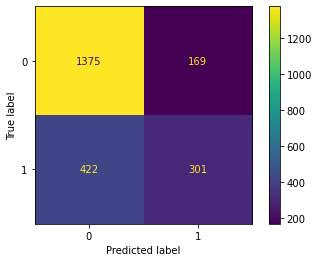

In [66]:
rf_ct = evaluate_model(clf_forest_2, cv_X_test_vec_forest, y_test, plot_cf = True)

In [67]:
# Logistic regression
vectorizer_log = TfidfVectorizer()  
vectorizer_log.fit(X_train)
X_train_vec_log = vectorizer_log.transform(X_train)
X_test_vec_log = vectorizer_log.transform(X_test)

clf_log = LogisticRegression()
clf_log.fit(X_train_vec_log, y_train)
clf_log.score(X_test_vec_log, y_test)

0.7441552712836348

Accuracy: 0.7442
Precision: 0.7365
Recall: 0.7442
F1 Score: 0.7133
ROC: 0.7584


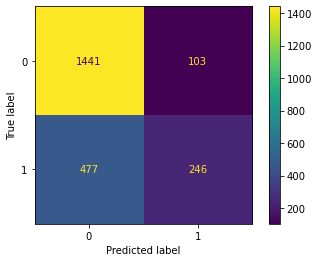

In [68]:
log_reg_tf = evaluate_model(clf_log, X_test_vec_log, y_test, plot_cf = True)

In [69]:
cv_vectorizer_log = CountVectorizer()  
cv_vectorizer_log.fit(X_train)
cv_X_train_vec_log = cv_vectorizer_log.transform(X_train)
cv_X_test_vec_log = cv_vectorizer_log.transform(X_test)

clf_log_2 = LogisticRegression()
clf_log_2.fit(cv_X_train_vec_log, y_train)
clf_log_2.score(cv_X_test_vec_log, y_test)

/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7498897220996912

Accuracy: 0.7499
Precision: 0.7383
Recall: 0.7499
F1 Score: 0.7373
ROC: 0.7573


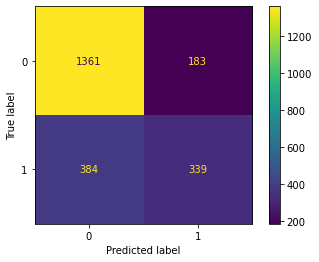

In [70]:
log_reg_ct = evaluate_model(clf_log_2, cv_X_test_vec_log, y_test, plot_cf = True)

In [71]:
from xgboost import XGBClassifier

In [72]:
vectorizer_xg = TfidfVectorizer()  
vectorizer_xg.fit(X_train)
X_train_vec_xg = vectorizer_xg.transform(X_train)
X_test_vec_xg = vectorizer_xg.transform(X_test)

clf_xg = XGBClassifier()
clf_xg.fit(X_train_vec_xg, y_train)
clf_xg.score(X_test_vec_xg, y_test)

0.7459197176885752

Accuracy: 0.7459
Precision: 0.7343
Recall: 0.7459
F1 Score: 0.7235
ROC: nan


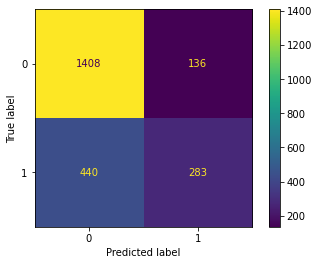

In [73]:
boost_tf = evaluate_model(clf_xg, X_test_vec_xg, y_test, plot_cf = True)

In [74]:
ct_vectorizer_xg = CountVectorizer()  
ct_vectorizer_xg.fit(X_train)
ct_X_train_vec_xg = vectorizer_xg.transform(X_train)
ct_X_test_vec_xg = vectorizer_xg.transform(X_test)

ct_clf_xg = XGBClassifier()
ct_clf_xg.fit(ct_X_train_vec_xg, y_train)
ct_clf_xg.score(ct_X_test_vec_xg, y_test)

0.7459197176885752

Accuracy: 0.7459
Precision: 0.7343
Recall: 0.7459
F1 Score: 0.7235
ROC: nan


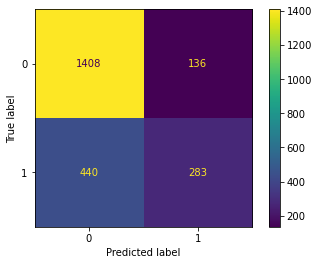

In [75]:
boost_ct = evaluate_model(ct_clf_xg, ct_X_test_vec_xg, y_test, plot_cf = True)

In [76]:
# Create dataframe to store the results
index = ['svm_ct', 'svm_tf', 'bayes_ct', 'bayes_tf', 'rf_ct', 'rf_tf', 'log_reg_ct',
         'log_reg_tf', 'boost_ct', 'boost_tf']
cols = ['Accuracy', 'Precision', 'Recall', 'F1']
df_results = pd.DataFrame(index=index, columns=cols)

In [77]:
range_index = [svm_ct, svm_tf, bayes_ct, bayes_tf, rf_ct, rf_tf, log_reg_ct,
               log_reg_tf, boost_ct, boost_tf]
# b = 0
for i, x in enumerate(range_index):
    df_results.iloc[i,:] = x 
    



In [78]:
df_results

,Accuracy,Precision,Recall,F1
svm_ct,0.753419,0.750985,0.753419,0.722601
svm_tf,0.753419,0.745917,0.753419,0.728309
bayes_ct,0.707543,0.699708,0.707543,0.70274
bayes_tf,0.721217,0.725575,0.721217,0.660569
rf_ct,0.739303,0.725382,0.739303,0.721531
rf_tf,0.740185,0.726501,0.740185,0.720097
log_reg_ct,0.74989,0.738318,0.74989,0.737343
log_reg_tf,0.744155,0.736495,0.744155,0.713345
boost_ct,0.74592,0.734322,0.74592,0.723487
boost_tf,0.74592,0.734322,0.74592,0.723487


### Tunining the svm model

In [83]:
from sklearn.model_selection import GridSearchCV

In [96]:
param_grid = {'C': [0.1,1, 10, 100],"class_weight": ['balanced', None]}

In [97]:
tuned_svm = GridSearchCV(SVC(random_state=15), param_grid=param_grid)
tuned_svm.fit(cv_X_train_vec_svm, y_train)

GridSearchCV(estimator=SVC(random_state=15),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None]})

In [98]:
print(tuned_svm.best_estimator_)

SVC(C=1, random_state=15)


In [99]:
best_svc = SVC(C=1, random_state=15)
best_svc.fit(cv_X_train_vec_svm, y_train)
best_svc.score(cv_X_test_vec_svm, y_test)

0.7534186149095721

Accuracy: 0.7534
Precision: 0.7510
Recall: 0.7534
F1 Score: 0.7226
ROC: 0.7813


(0.7534186149095721,
 0.7509854331373501,
 0.7534186149095721,
 0.7226010960482748)

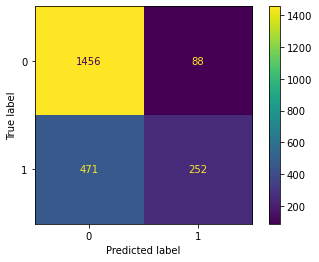

In [100]:
evaluate_model(best_svc, cv_X_test_vec_svm, y_test, plot_cf=True)

In [90]:
param_grid_2 = {'C': [0.1,1, 10, 100],'tol': [1e-3, 1e-4, 1e-5],
                        'max_iter': [1000, 10000]}
tuned_svm_2 = GridSearchCV(SVC(class_weight="balanced", random_state=15),
                           param_grid=param_grid_2, verbose=2)
tuned_svm_2.fit(cv_X_train_vec_svm, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   1.1s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................
[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   1.0s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................
[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   1.0s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................
[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   1.0s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................
[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   1.0s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................
[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   1.0s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................
[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   1.0s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................
[CV] .

[CV] ................... C=1, max_iter=10000, tol=1e-05, total=   5.2s
[CV] C=1, max_iter=10000, tol=1e-05 ..................................
[CV] ................... C=1, max_iter=10000, tol=1e-05, total=   5.1s
[CV] C=10, max_iter=1000, tol=0.001 ..................................
[CV] ................... C=10, max_iter=1000, tol=0.001, total=   1.5s
[CV] C=10, max_iter=1000, tol=0.001 ..................................
[CV] ................... C=10, max_iter=1000, tol=0.001, total=   1.4s
[CV] C=10, max_iter=1000, tol=0.001 ..................................
[CV] ................... C=10, max_iter=1000, tol=0.001, total=   1.5s
[CV] C=10, max_iter=1000, tol=0.001 ..................................
[CV] ................... C=10, max_iter=1000, tol=0.001, total=   1.6s
[CV] C=10, max_iter=1000, tol=0.001 ..................................
[CV] ................... C=10, max_iter=1000, tol=0.001, total=   1.5s
[CV] C=10, max_iter=1000, tol=0.0001 .................................
[CV] .

/Users/mac/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] .................. C=10, max_iter=10000, tol=0.001, total=   5.1s
[CV] C=10, max_iter=10000, tol=0.001 .................................
[CV] .................. C=10, max_iter=10000, tol=0.001, total=   4.7s
[CV] C=10, max_iter=10000, tol=0.001 .................................
[CV] .................. C=10, max_iter=10000, tol=0.001, total=   5.1s
[CV] C=10, max_iter=10000, tol=0.001 .................................
[CV] .................. C=10, max_iter=10000, tol=0.001, total=   5.1s
[CV] C=10, max_iter=10000, tol=0.001 .................................
[CV] .................. C=10, max_iter=10000, tol=0.001, total=   5.1s
[CV] C=10, max_iter=10000, tol=0.0001 ................................
[CV] ................. C=10, max_iter=10000, tol=0.0001, total=   4.7s
[CV] C=10, max_iter=10000, tol=0.0001 ................................
[CV] ................. C=10, max_iter=10000, tol=0.0001, total=   4.7s
[CV] C=10, max_iter=10000, tol=0.0001 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  6.2min finished


GridSearchCV(estimator=SVC(class_weight='balanced', random_state=15),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [1000, 10000],
                         'tol': [0.001, 0.0001, 1e-05]},
             verbose=2)

In [91]:
print(tuned_svm_2.best_estimator_)

SVC(C=10, class_weight='balanced', max_iter=10000, random_state=15)


In [92]:
good_svc = SVC(C=10, class_weight='balanced', max_iter=10000, random_state=15)
good_svc.fit(cv_X_train_vec_svm, y_train)
good_svc.score(cv_X_test_vec_svm, y_test)

0.733127481252757

Accuracy: 0.7331
Precision: 0.7269
Recall: 0.7331
F1 Score: 0.7292
ROC: 0.7544


(0.733127481252757, 0.7268567663653398, 0.733127481252757, 0.7292363602749331)

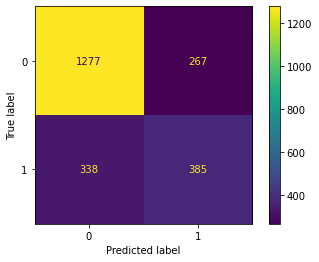

In [93]:
evaluate_model(good_svc, cv_X_test_vec_svm, y_test, plot_cf=True)

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
